In [ ]:
! pip install importlib-metadata==4.13.0
! pip install xarray==0.20.1
! pip install --upgrade xarray cftime nc-time-axis
! pip install netCDF4

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 7.1.0
    Uninstalling importlib_metadata-7.1.0:
      Successfully uninstalled importlib_metadata-7.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.7/835.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2023.7.0
    Uninstalling xarray-2023.7.0:
      Successfully uninstalled xarray-2023.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires xarray>=0.21.0, but you have xarray 0.20.1 which is incompatible.
xarray-einstats 0.7.0 requires xarray>=2022.09.0, but you have xarray 0.20.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Fo

In [ ]:
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import sys
import netCDF4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# plotting parameters
color_list = ['#000000', '#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#D55E00', '#CC79A7'] * 2
marker_list = ['o', 's', 'P', '+', 'D', 'v', '3', 'm'] * 2
markersize = 6
linewidth = 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
cdds_params={'axes.linewidth': 3,
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'axes.titlesize': 20,
 'axes.labelsize': 20,
 'axes.titlelocation': 'left',
 'figure.facecolor': 'white',
 'figure.figsize': (18, 10),
 'lines.solid_capstyle': 'round',
 'lines.linewidth': 2.5,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'legend.frameon': False,
 'xtick.bottom': True,
 'xtick.major.width': 3,
 'xtick.major.size': 6,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False,
 'ytick.color' : 'black',
 'ytick.major.width': 3,
 'ytick.major.size': 6,
 'axes.prop_cycle': plt.cycler(color=color_list),
 'font.size': 16,
 'font.family': 'serif'}
plt.rcParams.update(cdds_params)

Load Data and Remove Seasonal Cycle


##***Make sure to update your file location in google drive!!!***

<xarray.Dataset> Size: 647kB
Dimensions:  (model: 26, time: 2988)
Coordinates:
  * model    (model) <U16 2kB 'CanESM5' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * time     (time) datetime64[ns] 24kB 1851-01-31 1851-02-28 ... 2099-12-31
Data variables:
    pr       (model, time) float64 622kB 3.292e-05 3.256e-05 ... 3.435e-05

In [ ]:
#remove seasonal cycle
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds = ds.groupby('time.month').apply(remove_time_mean)
ds

<xarray.Dataset> Size: 647kB
Dimensions:  (model: 26, time: 2988)
Coordinates:
  * model    (model) <U16 2kB 'CanESM5' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * time     (time) datetime64[ns] 24kB 1851-01-31 1851-02-28 ... 2099-12-31
Data variables:
    pr       (model, time) float64 622kB -9.814e-07 -1.007e-06 ... 1.386e-06

##Trends

Function to calculate and apply the trends for a time series over a specified time period

In [ ]:
#historical period found in Fig 3
historical_period = slice("1975", "2014")

In [ ]:
def get_trends(time_series, time_period):
    """Calculates and applies the trends for a time series over a specified time period

    Parameters
    ----------
    time_series: xarray `DataSet` object
        `DataSet` with time series for variable, must have time as a data variable

    time_period: string
        the time period (in years) that you want the trends to be applied for

    Returns
    -------
    trends_ds: xarray `DataSet` object
        applied trend for the time series over the time period, has "tas_polyfit_coefficients" as data variable with dimensions of model and degree
    """
    #calculate trends for the time period
    time = time_series.time

    #sub-select for desired time period (historical in our case)
    time_period = time_series.sel(time=time_period)

    #convert to seconds and add to dataset
    seconds = (time_period.time.astype(float).values / 1000000000)
    time_series_seconds = time_period.copy()
    time_series_seconds = time_series_seconds.assign(time = seconds)

    #compute polyfit values
    trends_ds = time_series_seconds.polyfit(dim = "time", deg = 1)


    #return trends
    return trends_ds

##Sij

described in methods

In [ ]:
#convert time to seconds store it as variable
seconds = (ds.time.astype(float).values / 1000000000)

#calculate trends for the dataset over the historical period
ds_trends = get_trends(ds, historical_period)


#calculate the distance between models i and j for every model where j cycles through every model
#making empty dataset with 27 models and 26 distances for each model
Sij = np.zeros((ds.model.shape[0], ds.model.shape[0] - 1))
distances = np.zeros((ds.model.shape[0] - 1))


for i in range(ds.model.shape[0]) :
#calcuate trend and mean for chosen i model
  dT_i = ((seconds) * (ds_trends.pr_polyfit_coefficients[0, i].values))
  dT_i = dT_i.mean()

#remove i from chosen j models
  for j in range(ds.model.shape[0] - 1) :
    ds_copy = ds.copy()
    removed_i= ds_copy.where(ds_copy.model != ds_copy.model[i], drop=True)

#calculate trend and mean for chosen j model
    removed_i_trends = get_trends(removed_i, historical_period)
    dT_j = ((seconds) * (removed_i_trends.pr_polyfit_coefficients[0, j].values))
    dT_j = dT_j.mean()

#find distance between i and j model means
    distances[j] = abs(dT_i - dT_j)

#add the distance to Sij dataset
  Sij[i] = distances


#find median of Sij, which is important as a normalization value in the weighting process
median = np.median(Sij)

##Weights

In [ ]:
def get_weights(trends, pseudo_ind, time_series, time_period, Sij, models, remove_pseudo=True):
    """Calculates the weights for a time series and given pseudo obsersation

    Parameters
    ----------
    trends: xarray `DataSet` object
        applied trend for the time series over the time period, has "tas_polyfit_coefficients" as data variable with dimensions of model and degree

    pseudo_ind: integer
        the index value for the chosen pseudo observation model

    time_series: xarray `DataSet` object
        `DataSet` with time series for variable, must have time as a data variable

    time_period: string
        the time period (in years) that you want the trends to be applied for

    Sij: array
        calculated above, the distance between models i and j for every model

    models: integer
        the number of models after dropping pseudo, 25 for precipitation

    Returns
    -------
    weights_normed: array
        the weighted values of each model for the ensemble given in time_series
    """
    #slice the time series to the specific time period and convert that time to seconds in order to apply the trends
    time_period = time_series.sel(time=time_period)
    seconds = (time_period.time.astype(float).values / 1000000000)

    #find mean value of the chosen pseudo observation's trend
    #important in finding the distances between the pseudo observation and chosen model
    pseudo_trend = (seconds) * (trends.pr_polyfit_coefficients[0, pseudo_ind].values)
    pseudo_mean = pseudo_trend.mean()

    #below is normalization for sigma d and sigma s
    #median_D is median of Sij at the pseudo_ind
    median_D = np.median(Sij[pseudo_ind])

    #median_S is the median of Sij without the pseudo observation included
    Sij_pseudo_dropped = np.delete(Sij, pseudo_ind, axis=0)
    median_S = np.median(Sij_pseudo_dropped)

    #remove pseudo from ensemble so it is not weighted (defaultly set to true)
    if remove_pseudo:
      trends = trends.where(trends.model != trends.model[pseudo_ind], drop=True)

    #calculate weights for each ensemble member based on equation
    weights = list()
    for source in range(len(trends.model)):
        #find mean value of the chosen model's trend
        dT_i = ((seconds) * (trends.pr_polyfit_coefficients[0, source].values))
        dT_i_mean = dT_i.mean()

        #find the distance between model i and observations, using the mean of the trends for each
        distance = dT_i_mean - pseudo_mean

        #sigma_d is a value previously optimized
        sigma_d = 0.34

        #calculate numerator of weighting equation, normalize with median_D
        weight_numerator = np.exp(-(distance**2 / (median_D * sigma_d)**2))
        #sigma_s is a value previously optimized
        sigma_s = 0.01

        #calculate denominator of weighting equation, normalize with median_S
        weight_denominator = 1 + np.sum(np.exp(-(Sij[source]**2 /(median_S * sigma_s**2))))

        #in practice, weight_denominator does not make a signficant difference in the weights
        weight = weight_numerator /weight_denominator
        weights.append(weight)


    weights_reshape = np.reshape(weights, models,)

    #normalize again by the sum of the weights
    weights_normed = weights/np.sum(weights)



    return weights_normed

##Obtain temperature weights and save to netCDF

In [ ]:
#create empty structure
weights_save = np.zeros((ds.model.shape[0], ds.model.shape[0] - 1))

#fill weights_save with weighted values for each pseudo observation choice
for i in range(ds.model.shape[0]) :
  weights_list = get_weights(ds_trends, i, ds, slice("1850", "2099"), Sij, 25)
  weights_save[i] = weights_list

#export these weights to a netcdf to be used for regional figures
weights = xr.DataArray(weights_save, name = "weights")
weights = weights.to_dataset()
weights = weights.rename_dims(dim_0 = 'pseudo_dropped')
weights = weights.rename_dims(dim_1 = 'models')


weights.to_netcdf("weights_precip.nc", mode = 'w', format = "NETCDF4", engine = 'netcdf4')

In [ ]:
#weights printed out
weights

<xarray.Dataset> Size: 5kB
Dimensions:  (pseudo_dropped: 26, models: 25)
Dimensions without coordinates: pseudo_dropped, models
Data variables:
    weights  (pseudo_dropped, models) float64 5kB 0.09331 0.1024 ... 3.307e-05

In [ ]:
W=list()
UW=list()

#apply weights for each pseudo choice
for i_obs in range(26):
    #select pseudo weights from the saved weights
    weights=weights_save[i_obs,:]

    #select pseudo from the data
    ds_obs=ds.isel(model=i_obs)

    #select all models but the pseudo from the data
    v=np.delete(np.arange(26), i_obs)
    ds_gcm=ds.isel(model=v)


    #add the weights to the dataset
    ds_gcm=ds_gcm.assign({"weights": ("model",weights)})

    #apply the weights to the dataset
    ds_gcm=ds_gcm.assign(pr_fut_weights=ds_gcm.pr*ds_gcm.weights)

    #apply common baseline to the data
    #weights become 0 after this line but thats okay bc we already applied the weights and dont use the weights again
    ds_gcm = ds_gcm.sel(time=slice('2080', '2099')).mean(dim='time')-ds_gcm.sel(time=slice('1975', '2014')).mean(dim='time')

    #apply common baseline to the pseudo
    fut_period = ds_obs.sel(time=slice('2080', '2099')).mean(dim='time')-ds_obs.sel(time=slice('1975', '2014')).mean(dim='time')


    #find weighted mean difference
    y_w  =np.abs(fut_period - ds_gcm.pr_fut_weights.sum('model'))

    #find unweighted mean difference
    y_uw =np.abs(fut_period - ds_gcm.pr.mean('model'))

    #add to list for this pseudo choice and move onto the next pseudo choice
    W.append(y_w)
    UW.append(y_uw)


Y_W = xr.concat(W, dim = 'model',coords='minimal',compat='override')
Y_UW = xr.concat(UW, dim = 'model',coords='minimal',compat='override')


##plot RMSE

In [ ]:
weighted_distribution = Y_W.pr.values
unweighted_distribution = Y_UW.pr.values

In [ ]:
# previous figure

# #plotting weighted and unweighted histograms on the same figure
# fig = sns.kdeplot(weighted_distribution, fill=True, color="r", label='weighted') #.set(title="Precipitation Based on Precipitation")
# fig = sns.kdeplot(unweighted_distribution, fill=True, color="b", label='unweighted')

# fig.set_xlim([-0.5e-6, 1.5e-6])
# fig.set_ylim([0, 1000000])
# # fig.legend(fontsize = 24)
# fig.set_xlabel("Error (kg m$^{-2}$ s$^{-1}$)", fontsize = 30)
# fig.xaxis.set_tick_params(labelsize=30)
# fig.yaxis.set_tick_params(labelsize=30)
# fig.set_ylabel("Density", fontsize = 30)
# # plt.xlabel("Distance between Model and Pseudo Observation")
# sns.despine(trim=True, offset=5)
# plt.show()



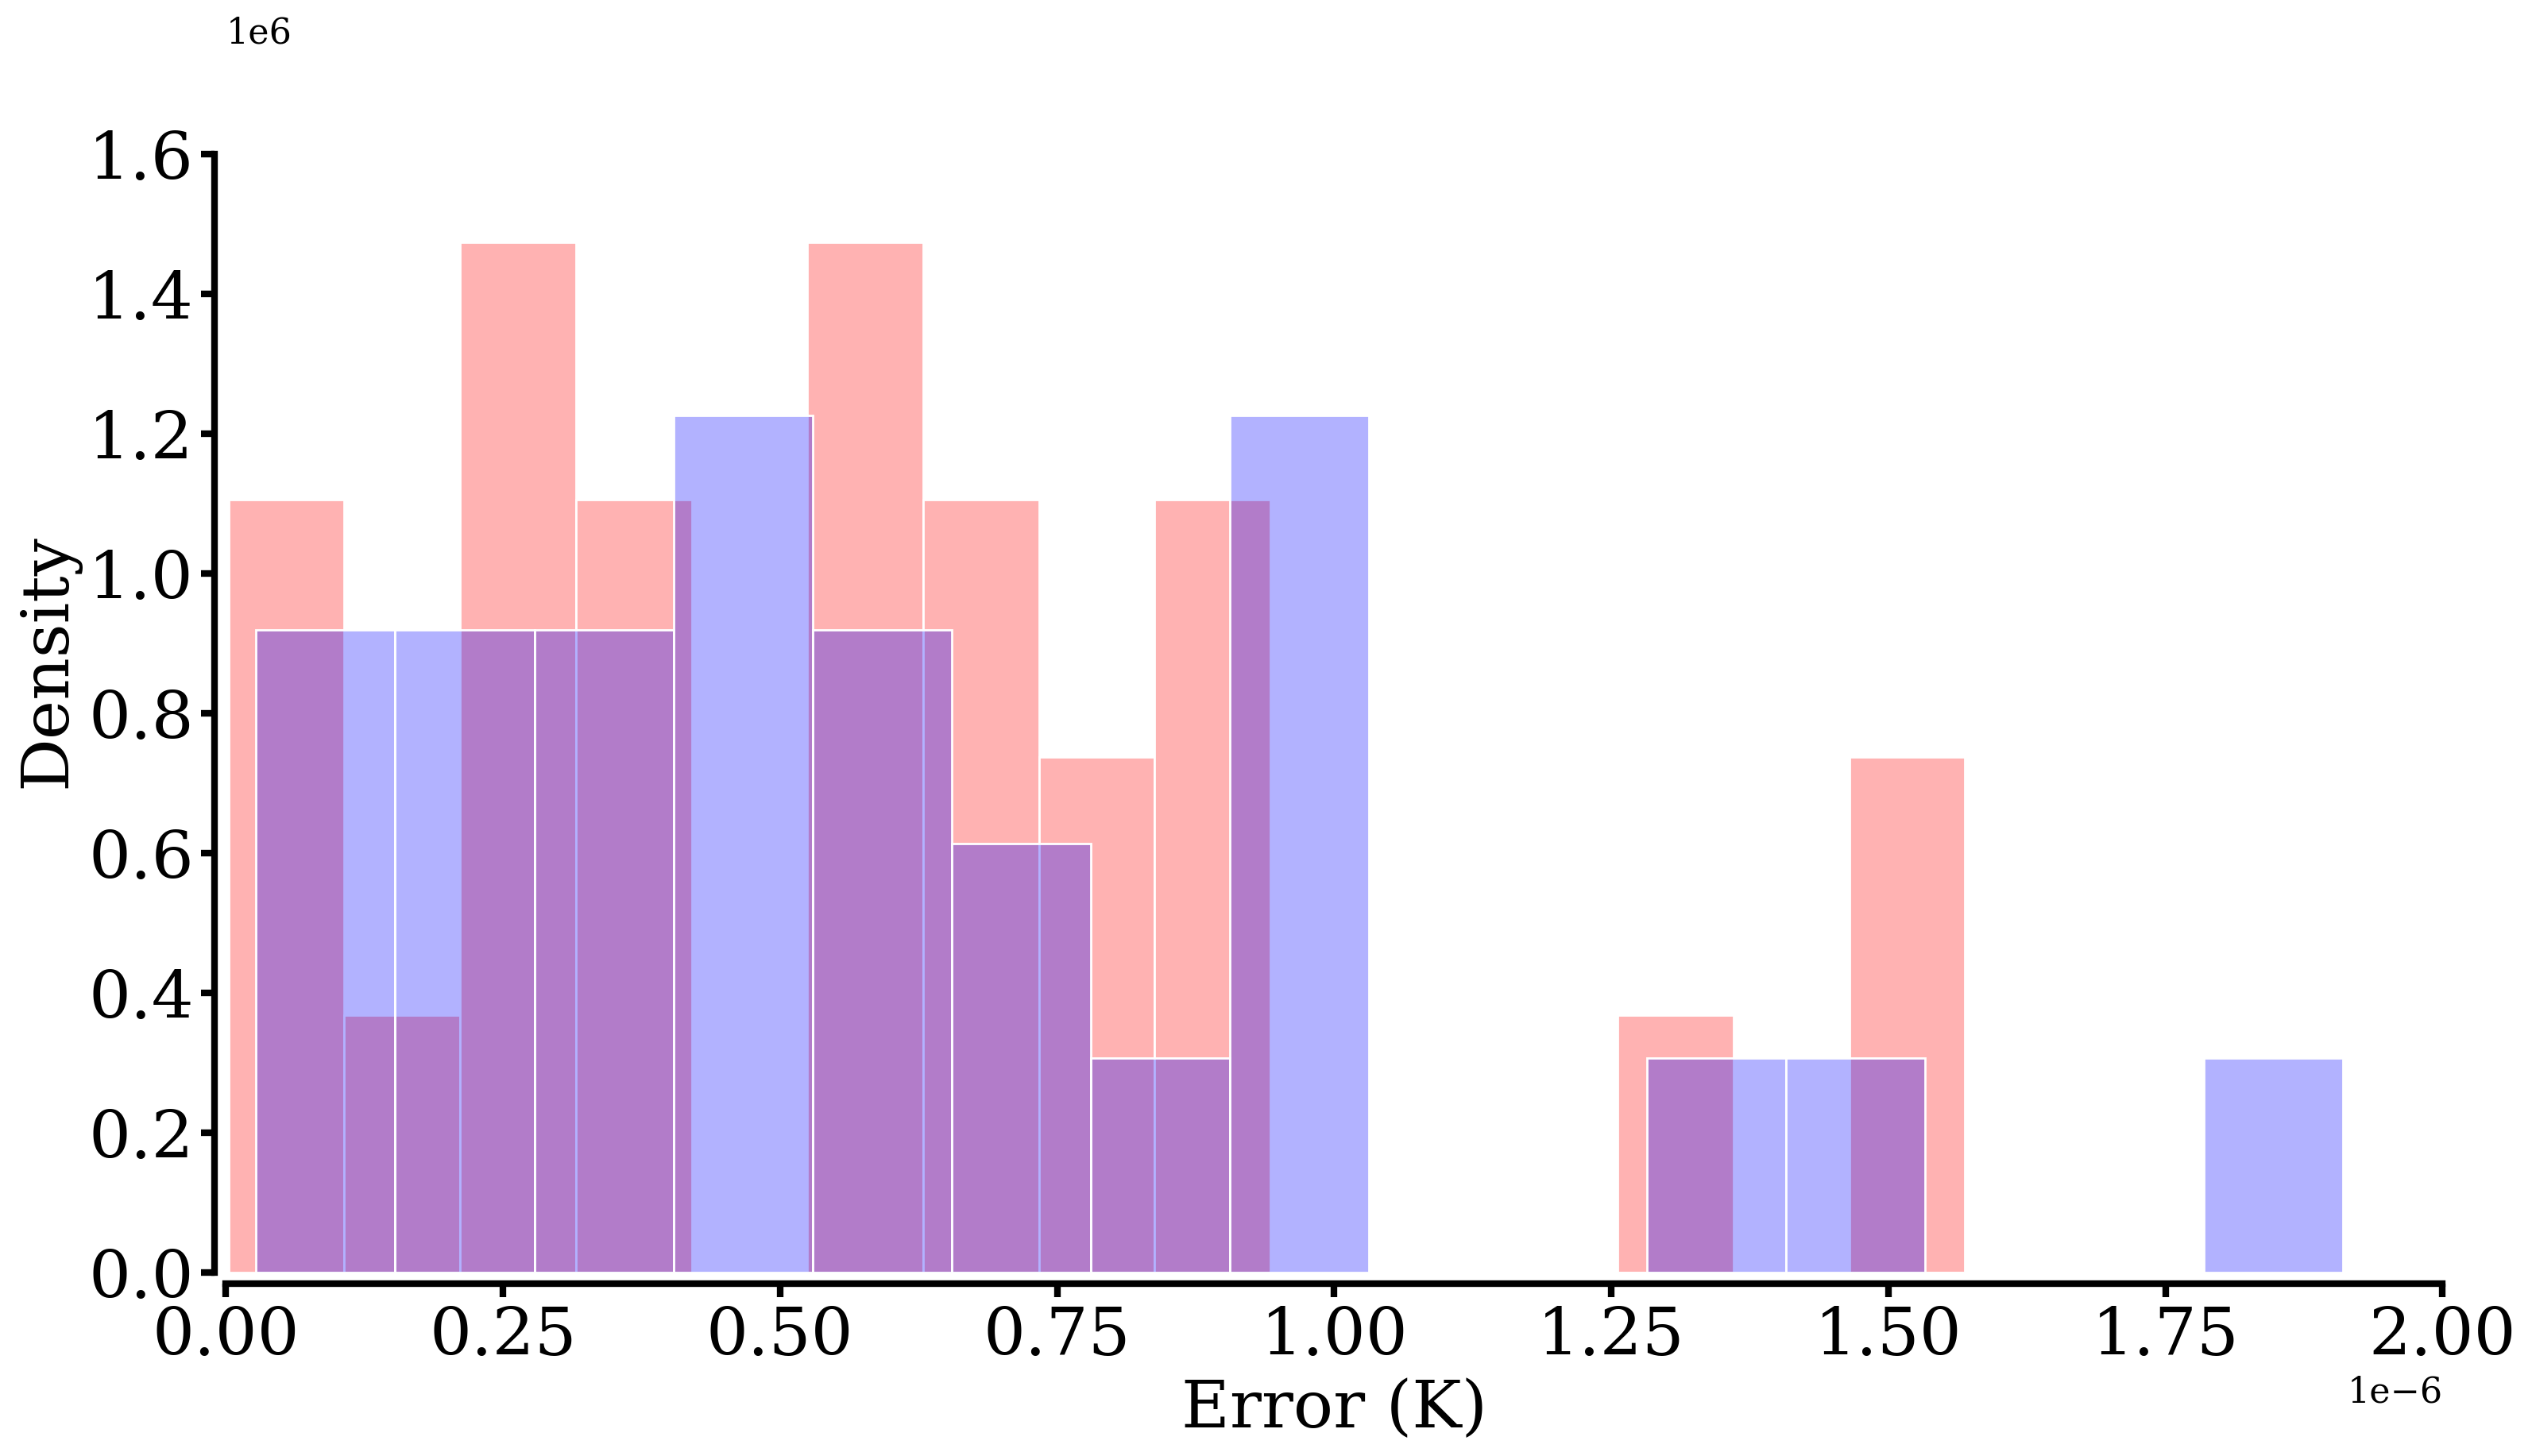

In [ ]:
import seaborn as sns

#plotting weighted and unweighted histograms on the same figure
sns.histplot(weighted_distribution, color="red", label='weighted', kde=False, stat="density", alpha=0.3, bins = 15)
sns.histplot(unweighted_distribution, color="blue", label='unweighted', kde=False, stat="density", alpha=0.3, bins = 15)

#density line
# sns.kdeplot(weighted_distribution, fill=False, color="red")
# sns.kdeplot(unweighted_distribution, fill=False, color="blue")


plt.xlim([0, 2e-6])
plt.ylim([0, 1.75e6])
plt.xlabel("Error (K)", fontsize = 30)
plt.ylabel("Density", fontsize = 30)


ax = plt.gca()
ax.tick_params(axis='both', labelsize=30)


sns.despine(trim=True, offset=5)
plt.show()

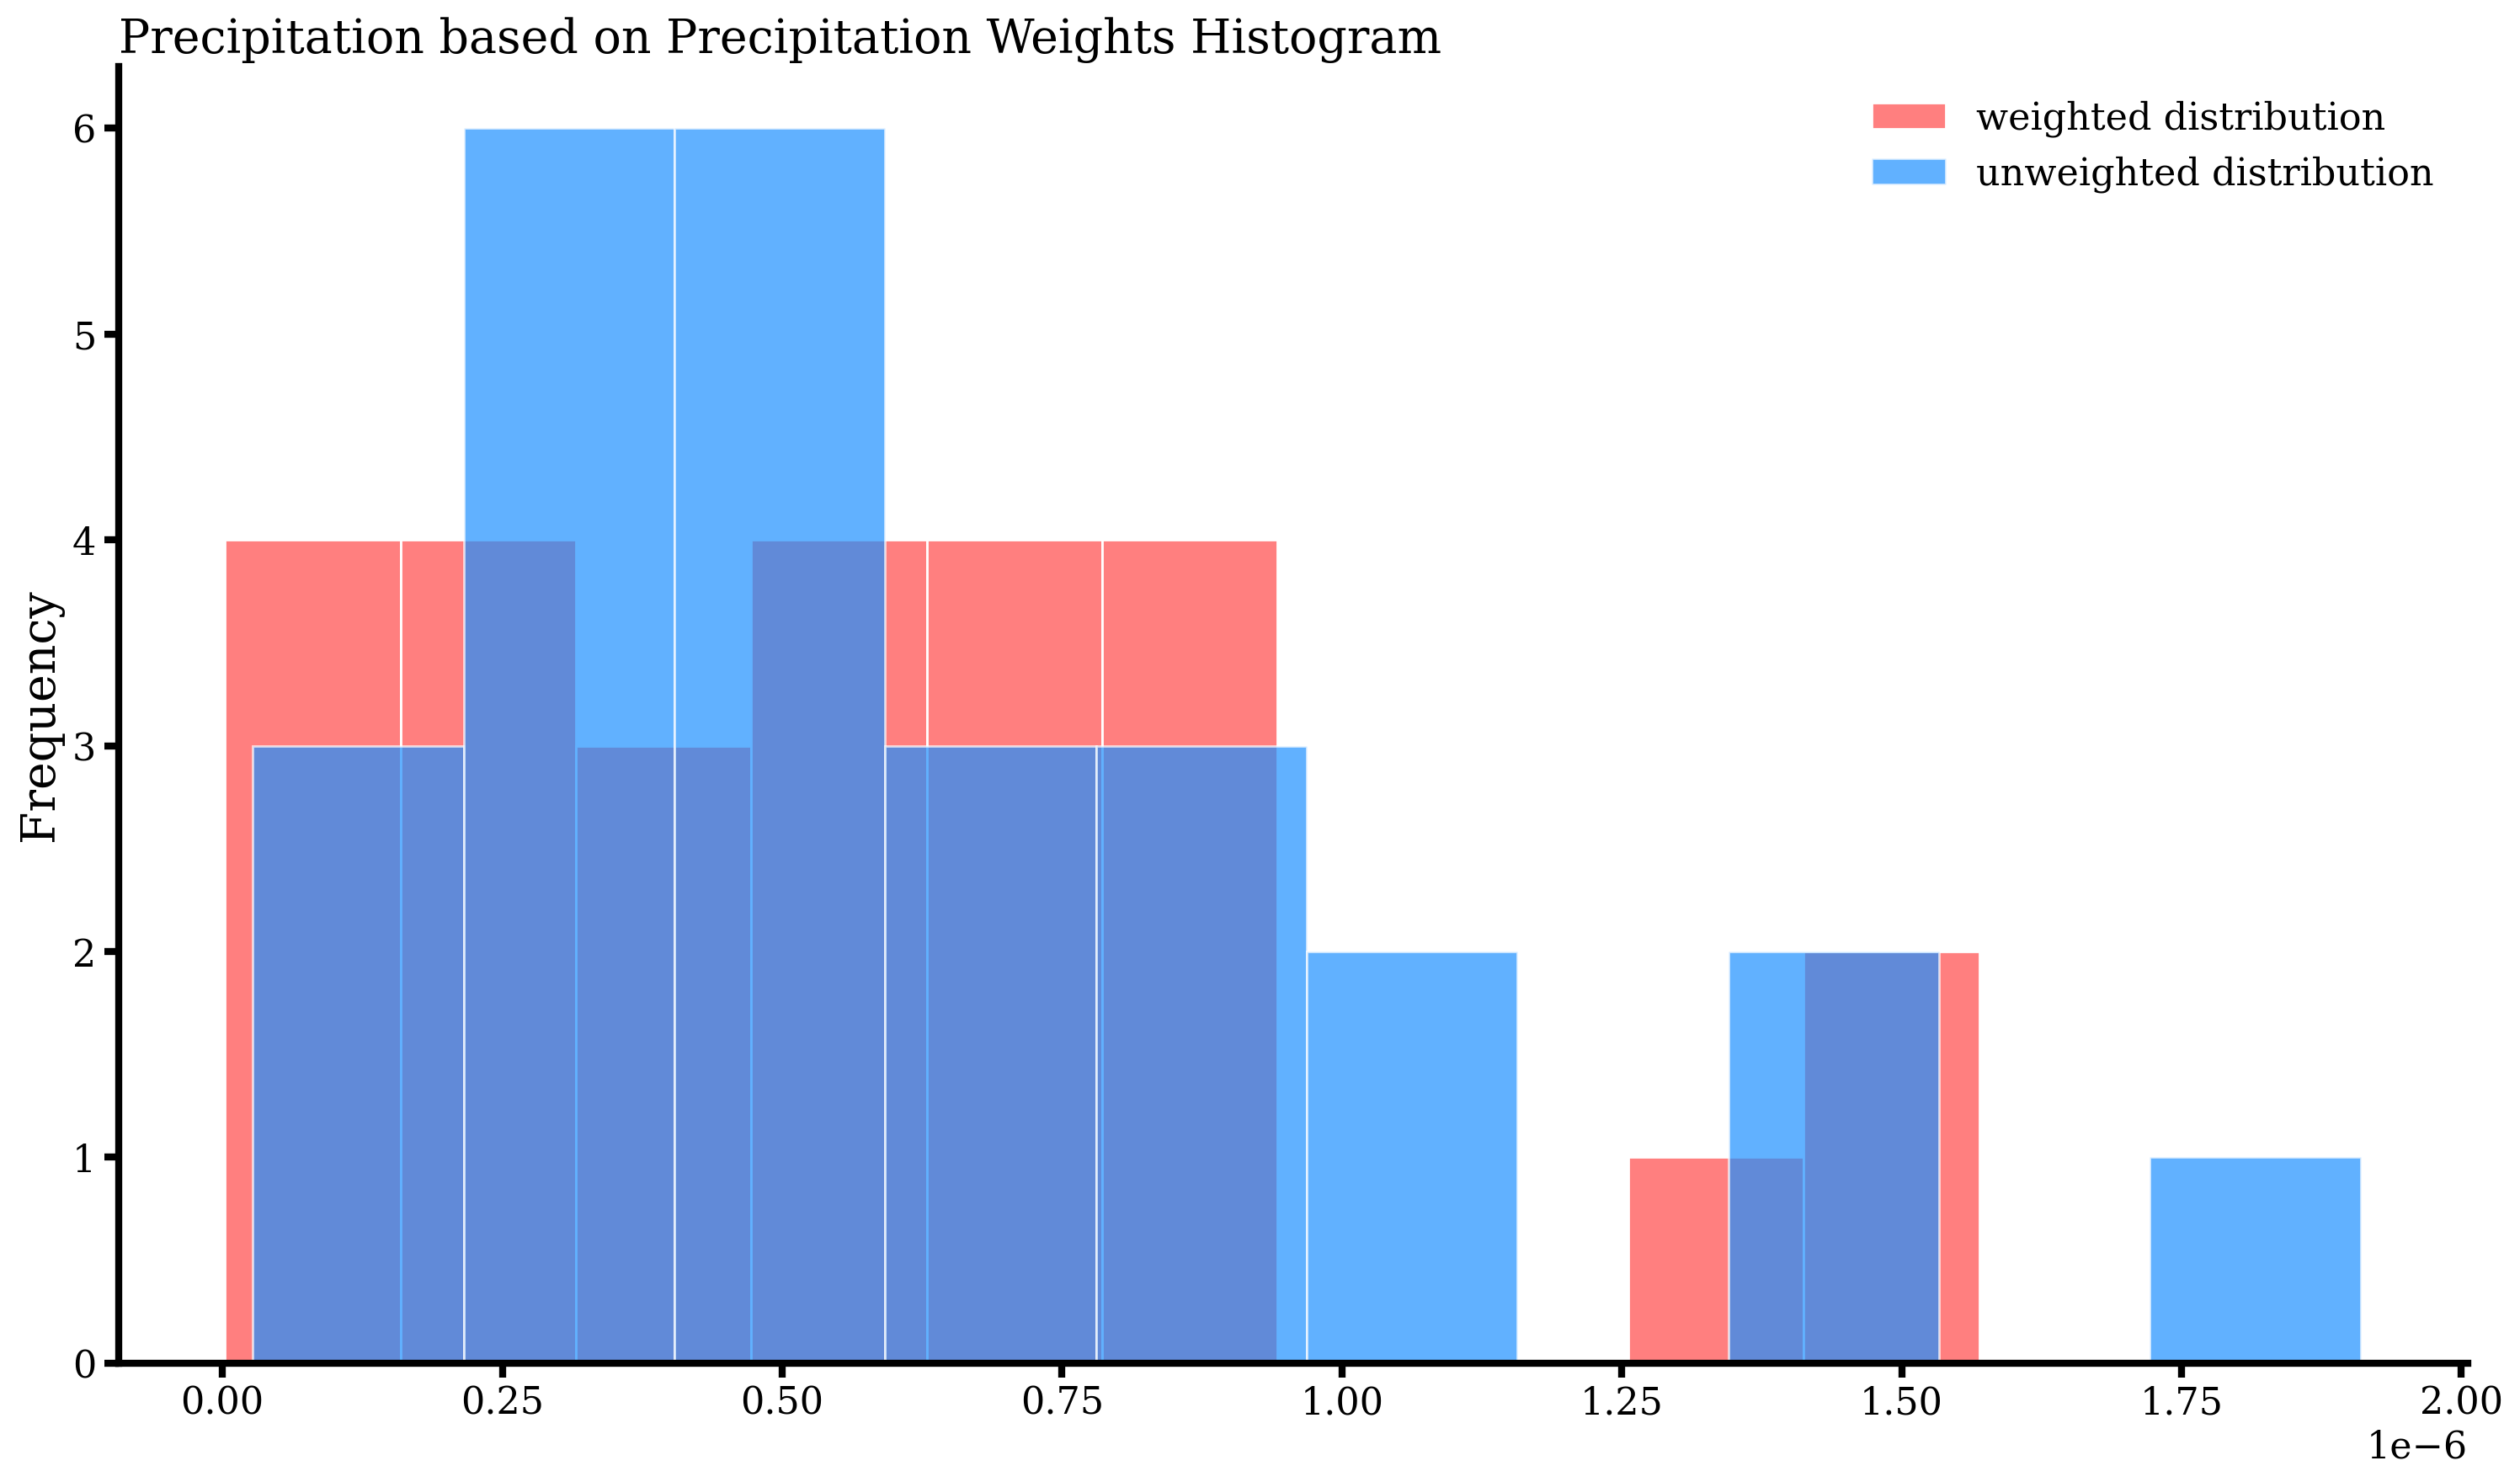

In [ ]:
plt.title("Precipitation based on Precipitation Weights Histogram")

plt.ylabel("Frequency")

plt.hist(weighted_distribution, label="weighted distribution", color = '#FF7F7F')
plt.hist(unweighted_distribution, label="unweighted distribution", color = '#1E90FF', alpha=0.7)

plt.legend()

Compare Variance

In [ ]:
(np.var(weighted_distribution)) / np.var(unweighted_distribution)

0.8254193519489239

Compare Median

In [ ]:
(np.median(weighted_distribution)) / np.median(unweighted_distribution)

1.1293758694891158

Compare RMSE

In [ ]:
RMSE = ((weighted_distribution - weighted_distribution.mean())**2).mean()
RMSE = np.sqrt(RMSE)
RMSE

4.1000874764592224e-07

In [ ]:
RMSE_unweighted = ((unweighted_distribution - unweighted_distribution.mean())**2).mean()
RMSE_unweighted = np.sqrt(RMSE_unweighted)
RMSE_unweighted

4.5129009252068405e-07

In [ ]:
RMSE/RMSE_unweighted

0.9085259225519786